In [26]:
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, LSTM, GRU, SimpleRNN, Embedding, TimeDistributed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from datetime import datetime
from IPython.display import Image
from collections import deque
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import time
import os
%run ARIMA-creator.ipynb

In [2]:
def generator(data, arima_data, fin_data, lookback, delay, indices, batch_size=32):
    """ Creates a generator for the given data. Returns each 
    batch with separate word embeddings and ARIMA-predictions. 
    
    Parameters: 
    data - Sorted data of size (n,d)
    arima_data - Predictions from the arima-models 
    lookback - How far back to include data (days)
    delay - How far ahead to predict (days)
    indices - Shuffled indices to include, where the order is followed
    batch_size - How many samples to return each call 
    
    Returns: 
    samples_words - Word-related data 
    samples_arima - The ARIMA-predicted future value 
    targets - The value of the times series delay days ahead
    
    """
    min_index = lookback
    max_index = len(data) - delay - 1
    current_batch_start = 0
    while True:
        if current_batch_start > len(indices): 
            current_batch_start = 0
        rows = indices[current_batch_start:min(current_batch_start+batch_size,max_index)]
        current_batch_start += batch_size
        samples_words = np.zeros((len(rows), lookback, data.shape[-1]))
        samples_arima = np.zeros(len(rows),)
        targets = np.zeros(len(rows),)
        dates = []
        for i, index in enumerate(rows): 
            date = arima_data.index[index]
            dates.append(date)
            target_date = date + timedelta(days=delay)     # Does this always give a viable date? 
            if (index > min_index) and (index < max_index):
                samples_words[i] = data[range(index - lookback,index)]
                samples_arima[i] = arima_data[date]
                targets[i] = fin_data.loc[target_date]
        yield [samples_words, samples_arima], targets

        
def concat_daily(df):
    conc = pd.DataFrame()
    for i in set(df.index):
        concat_str = ''
        for title in df.loc[i]['title']:
            concat_str += " " + title
        conc = conc.append({'date':i, 'title':concat_str},ignore_index=True)
    conc.set_index('date',inplace=True)
    conc = conc.sort_values('date')
    return conc

def pad_data(seq,maxlen):
    data = np.zeros((len(seq), maxlen),dtype=int)
    for i,s in enumerate(seq): 
        if len(s) <= maxlen: 
            data[i,:len(s)] = s
        else: 
            s = np.array(s)
            indices = np.sort(np.random.choice(len(s),maxlen,replace=False))
            data[i,:] = s[indices]
    return data
    

In [3]:
# Set up hyperparameters to be saved in a config file later. 
par = {
    'embed_dim': 100,    # Dimensions to use for the word embedding
    'vocab_part': 0.6,   # How large part of the total vocabulary to include
    'lookback': 20,      # How far back to collect data in the recurrent layer (days)
    'delay': 5,          # How far ahead to predict data (days)
    'batch_size': 10,    # Batch size used in generator
    'p': 1,              # Order of the AR-part of the model
    'd': 1,              # Integrated order
    'q': 1,              # Included moving average terms 
    'train_part' : 0.6,  # Part of data to be used for training
    'val_part' : 0.2,    # Part of data to be used for validation
    'test_part' : 0.2,   # Part of data to be used for testing
    'series': '1 YEAR'   # What series we currently want to predict, '1 YEAR', '3 YEAR' or 'S&P'
}

In [4]:
# Load data 
news_path = Path(os.getcwd()) / "Datasets/data/financial_headlines_20061020-20131119.pkl"
stock_path = Path(os.getcwd()) / "Datasets/data/stock_data.pkl"
data = pd.DataFrame(pd.read_pickle(news_path))
data.set_index('date',inplace=True)
stock_data = pd.DataFrame(pd.read_pickle(stock_path))
data = concat_daily(data)

In [5]:
# Load and process text data 

len_words = [len(title) for title in data['title'].values]
mean_words = np.mean(len_words)
std_words = np.std(len_words)

sent_len = int(mean_words + 2 * std_words)  # THIS MAKES IT SLOW!?                                                                                                                                                        
sent_len = 500


# Update environment variable config
par.update({'input_dim': sent_len})
par.update({'start_date' : data.index[0]})
par.update({'end_date' : data.index[-1]})

# Tokenize the text data
tokenizer = Tokenizer(num_words=None)  # Tokenize without limitation first, just because it's a cheap way 
tokenizer.fit_on_texts(data['title'])  # of calculating the number of unique words in the data
par.update({'vocab_size': len(tokenizer.word_index)})

tokenizer = Tokenizer(num_words=par['vocab_size'] * par['vocab_part'])

tokenizer.fit_on_texts(data['title'])
sequences = tokenizer.texts_to_sequences(data['title'])

word_index = tokenizer.word_index

par.update({'vocab_size': len(word_index)})

In [6]:
# Pad sequences to the same length sent_len. End-padded.
# If a sequence is longer than sent_len, words are randomly sampled.
text_data = pad_data(sequences,sent_len)

# Extract financial data
stock_data = stock_data[par['start_date'] : par['end_date']]

# Add indicies which are present in the news data but not in the 
# financial data and interpolate missing values 
stock_data = stock_data.reindex(data.index.drop_duplicates())
stock_data = stock_data.interpolate()

# Normalize the financial data to [0,1]
fin_stats = pd.DataFrame(columns=['min','max'])
for col in stock_data: 
    minimum = min(stock_data[col])
    maximum = max(stock_data[col])
    fin_stats = fin_stats.append({'min':minimum, 'max':maximum},ignore_index=True)
    stock_data[col] = [(row - minimum) / (maximum - minimum) for row in stock_data[col]]
fin_stats.index = stock_data.columns

# Concatinate all data to one dataframe 
data = pd.DataFrame()
for text in text_data:
    data = data.append({'WORDS':text},ignore_index=True)
data['DATE'] = stock_data.index
data.set_index('DATE',inplace=True)
for col in stock_data: 
    data[col] = stock_data[col]

In [7]:
# Check if the ARIMA-models has been previously calculated for this config
# or if they have to be constructed
path = Path(f"./Models/ARIMA/all_mods_del{par['delay']}.pkl")
if os.path.exists(path):
    # Load model if if already exists
    ARIMA_models = pd.read_pickle(path)    
    print("Found and loaded previously constructed models.")
else: 
    # Fit ARIMA-models to all of the dates in the training data 
    print("Model not found, fitting models...")
    ARIMA_models = fit_all_models(par, data)
    ARIMA_models.to_pickle(path)    

Found and loaded previously constructed models.


In [8]:
# Predict 
arima_preds = predict_arima(ARIMA_models, par['delay'])

In [9]:
arima_preds

,1 YEAR,3 YEAR,S&P
date,,,
2006-11-10,0.975805,0.885219,0.486327
2006-11-11,0.978997,0.894900,0.487505
2006-11-12,0.979915,0.894458,0.488468
2006-11-13,0.981899,0.898712,0.489512
2006-11-14,0.975154,0.887344,0.497077
...,...,...,...
2013-11-15,0.008057,0.060185,0.999512
2013-11-16,0.008060,0.058758,0.998117
2013-11-17,0.008060,0.057422,0.996633


In [10]:
sequential_data = []
sequence_dates = []
prev_data = deque(maxlen=par['lookback'])
for i,row in enumerate(data['WORDS']): 
    prev_data.append(row)
    if len(prev_data) == par['lookback']:
        sequential_data.append(np.array(prev_data))
        sequence_dates.append(data.index[i])
sequential_data = np.asarray(sequential_data)



In [11]:
# Drop the values not in arima_preds. This is just values in the beginning where
# there isn't enough data to make a prediction, varies depending on lookback and delay. 
for date in data.index: 
    if not date in arima_preds.index : data.drop(index=date,inplace=True)
        
# Add the predicitons to the training data 
data['1 YEAR PRED'] = arima_preds['1 YEAR'].values
data['3 YEAR PRED'] = arima_preds['3 YEAR'].values
data['S&P PRED'] = arima_preds['S&P'].values

In [12]:
# Shift the target data (the actual rates) so that each row has a target rate 'delay' days in the future
data['1 YEAR'] = data['1 YEAR'].shift(-par['delay'])
data['3 YEAR'] = data['3 YEAR'].shift(-par['delay'])
data['S&P'] = data['S&P'].shift(-par['delay'])
data.dropna(inplace=True)

In [13]:
arima_preds = pd.DataFrame(np.zeros(2556))

In [14]:
arima_preds.shape

(2556, 1)

In [15]:
del_rows = []
for i,date in enumerate(sequence_dates): 
    if date not in data.index: del_rows.append(i)
keep_rows = np.setdiff1d(np.arange(len(sequential_data)),del_rows)
sequential_data = sequential_data[keep_rows]
        

In [16]:
# Divide the data into training, validation and test segments. 
indices = np.arange(len(data))
np.random.shuffle(indices)

# Here we extract the time series specified in 'par' (for some reason...)
words = np.array([row for row in data['WORDS'].values])
arima_preds = np.array([row for row in data[par['series'] + ' PRED'].values])
targets = np.array([row for row in data[par['series']].values])


training_samples = round(par['train_part'] * len(data))
validation_samples = round(par['val_part'] * len(data))
test_samples = round(par['test_part'] * len(data))

train_words = words[:training_samples - par['delay']]
train_seq = sequential_data[:training_samples - par['delay']]
train_arima = arima_preds[:training_samples - par['delay']]
train_targets = targets[:training_samples - par['delay']]

val_words = words[training_samples:training_samples + validation_samples - par['delay']]
val_seq = sequential_data[training_samples:training_samples + validation_samples - par['delay']]
val_arima = arima_preds[training_samples:training_samples + validation_samples - par['delay']]
val_targets = targets[training_samples:training_samples + validation_samples - par['delay']]

test_words = words[-test_samples:]
test_seq = sequential_data[-test_samples:]
test_arima = arima_preds[-test_samples:]
test_targets = targets[-test_samples:]


In [17]:
# Shuffle the data 
train_indices = np.arange(len(train_targets))
random.shuffle(train_indices)
train_words = train_words[train_indices]
train_seq = train_seq[train_indices]
train_arima = train_arima[train_indices]
train_targets = train_targets[train_indices]

val_indices = np.arange(len(val_targets))
val_words = val_words[val_indices]
val_seq = val_seq[val_indices]
val_arima = val_arima[val_indices]
val_targets = val_targets[val_indices]

test_indices = np.arange(len(test_targets))
test_words = test_words[test_indices]
test_seq = test_seq[test_indices]
test_arima = test_arima[test_indices]
test_targets = test_targets[test_indices]

In [18]:
# Initialize logging folder for TensorBoard
logdir=Path("./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
print(train_words.shape)
print(train_seq.shape)

(1529, 500)
(1529, 20, 500)


In [20]:
# Initialize the neural network
text_inputs = Input(shape=(par['input_dim']), name='Text_Input')

# Layer for word embedding
embedded_layer = Embedding(input_dim=par['vocab_size'],
                           output_dim=par['embed_dim'],
                           input_length=(par['input_dim']), name='Embedding_Layer')(text_inputs)

# LSTM-layer over the embedding layer 
lstm_out = LSTM(10)(embedded_layer)
dropout = Dropout(0.2)(lstm_out)

# Input from an ARIMA-model independently fitted to the training data. 
ARIMA_input = Input(shape=(1,), name='ARIMA_input')

# Merging the ARIMA-input and the input from the LSTM-layer. 
hidden = keras.layers.concatenate([dropout, ARIMA_input])

# Stack of dense layers 
#hidden = Dense(64, activation='relu',name='Dense_1')(hidden)
#hidden = Dropout(0.2)(hidden)

hidden = Dense(64, activation='relu',name='Dense_2')(hidden)
#hidden = Dropout(0.2)(hidden)

# Main output of the model
main_output = Dense(1,activation='linear',name='Main_Output')(hidden)

model = Model(inputs=[text_inputs, ARIMA_input],outputs=[main_output])

model.compile(optimizer='adam',
             loss='mse')
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
Embedding_Layer (Embedding)     (None, 500, 100)     2566400     Text_Input[0][0]                 
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10)           4440        Embedding_Layer[0][0]            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10)           0           lstm[0][0]                       
______________________________________________________________________________________________

In [21]:
data

,WORDS,1 YEAR,3 YEAR,S&P,1 YEAR PRED,3 YEAR PRED,S&P PRED
DATE,,,,,,,
2006-11-10,"[53, 309, 1526, 21, 3541, 6942, 18, 19, 5891, ...",0.984127,0.909278,0.495985,0.975805,0.885219,0.486327
2006-11-11,"[695, 713, 1364, 81, 1003, 513, 236, 507, 713,...",0.988095,0.921649,0.498327,0.978997,0.894900,0.487505
2006-11-12,"[50, 1, 498, 150, 241, 508, 770, 285, 1483, 5,...",0.980159,0.905155,0.499378,0.979915,0.894458,0.488468
2006-11-13,"[6, 4, 389, 12839, 60, 1243, 129, 220, 1301, 1...",0.980159,0.904467,0.499215,0.981899,0.898712,0.489512
2006-11-14,"[6929, 41, 6, 4, 1763, 1297, 95, 241, 14, 77, ...",0.980159,0.903780,0.499051,0.975154,0.887344,0.497077
...,...,...,...,...,...,...,...
2013-11-10,"[120, 1039, 3, 523, 9645, 12265, 10, 820, 848,...",0.009921,0.061856,1.000000,0.006076,0.068606,0.977189
2013-11-11,"[4936, 2, 59, 29, 977, 278, 934, 510, 66, 413,...",0.009921,0.060481,0.998156,0.006066,0.068291,0.977625
2013-11-12,"[295, 297, 2696, 1145, 1602, 529, 5860, 70, 16...",0.009921,0.059107,0.996312,0.008256,0.074854,0.974523


In [22]:
train_words.shape

(1529, 500)

In [23]:
train_seq.shape

(1529, 20, 500)

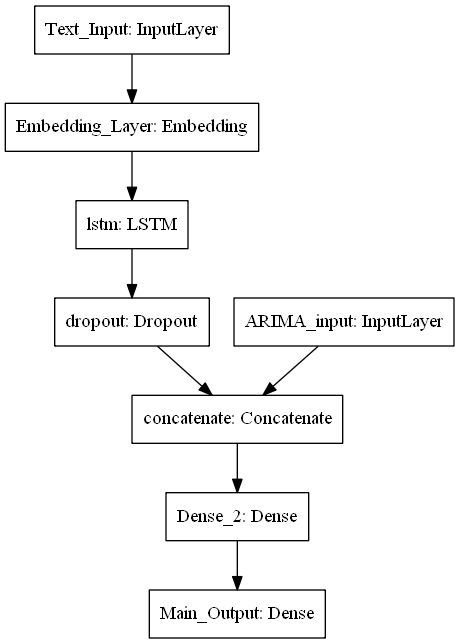

In [24]:
plot_model(model)

In [ ]:
h = model.fit({'Text_Input': train_words, 'ARIMA_input': train_arima},
              {'Main_Output': train_targets},
              validation_data=({'Text_Input': val_words, 'ARIMA_input': val_arima},
              {'Main_Output': val_targets}),
              batch_size=par['batch_size'],
              epochs=1)

In [ ]:
plt.plot(h.history['loss'],color="blue",label="Loss")
plt.plot(h.history['val_loss'],color="red",label="Val_Loss")
plt.legend()
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(range(5))
plt.show()

In [ ]:
# Save model and parameters
date_str = date.today().strftime("%y%h%d-%Hh%Mm")
dir_path = Path(f"./Models/model_del_{par['delay']}_t{date_str}")
os.mkdir(dir_path)
model_path = dir_path / "m.h5"
model.save(model_path)
config_path = dir_path / "config.pkl"
pickle.dump(par,open(config_path,'wb'))

In [ ]:
par

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 20, 500)]    0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 20, 500, 100) 2566400     Text_Input[0][0]                 
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 20, 50000)    0           time_distributed[0][0]           
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10)           2000440     time_distributed_1[0][0]         
____________________________________________________________________________________________

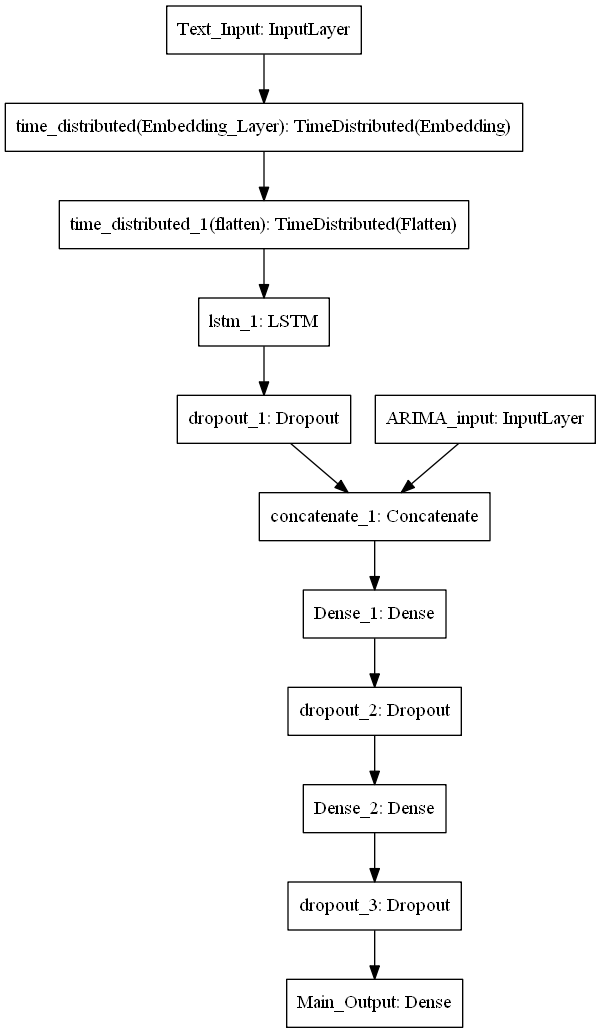

In [27]:
# Pierre's model
# Initialize the neural network
text_inputs = Input(shape=(par['lookback'],par['input_dim']), name='Text_Input')

# Layer for word embedding
embedded_layer = TimeDistributed(Embedding(input_dim=par['vocab_size'],
                           output_dim=par['embed_dim'],
                           input_length=par['input_dim'], name='Embedding_Layer'))(text_inputs)

embedded_layer = TimeDistributed(Flatten())(embedded_layer)

# LSTM-layer over the embedding layer 
lstm_out = LSTM(10, input_shape=(None,par['lookback'],par['embed_dim']))(embedded_layer)
dropout = Dropout(0.2)(lstm_out)

# Input from an ARIMA-model independently fitted to the training data. 
ARIMA_input = Input(shape=(1,), name='ARIMA_input')

# Merging the ARIMA-input and the input from the LSTM-layer. 
hidden = keras.layers.concatenate([dropout, ARIMA_input])

# Stack of dense layers 
hidden = Dense(64, activation='relu',name='Dense_1')(hidden)
hidden = Dropout(0.2)(hidden)

hidden = Dense(64, activation='relu',name='Dense_2')(hidden)
hidden = Dropout(0.2)(hidden)

# Main output of the model
main_output = Dense(1,activation='linear',name='Main_Output')(hidden)

model_p = Model(inputs=[text_inputs, ARIMA_input],outputs=[main_output])

model_p.compile(optimizer='adam',
             loss='mse')

model_p.summary()

plot_model(model_p)

In [34]:
par

{'embed_dim': 100,
 'vocab_part': 0.6,
 'lookback': 20,
 'delay': 5,
 'batch_size': 10,
 'p': 1,
 'd': 1,
 'q': 1,
 'train_part': 0.6,
 'val_part': 0.2,
 'test_part': 0.2,
 'series': '1 YEAR',
 'input_dim': 500,
 'start_date': Timestamp('2006-10-20 00:00:00'),
 'end_date': Timestamp('2013-11-19 00:00:00'),
 'vocab_size': 25664}

In [32]:
h_p = model_p.fit({'Text_Input': train_seq, 'ARIMA_input': train_arima},
              {'Main_Output': train_targets},
              validation_data=({'Text_Input': val_seq, 'ARIMA_input': val_arima},
              {'Main_Output': val_targets}),
              batch_size=par['batch_size'],
              epochs=5)

Train on 1529 samples, validate on 506 samples
Epoch 1/5
1529/1529 [==============================] - 43s 28ms/sample - loss: 0.0310 - val_loss: 1.8827e-04
Epoch 2/5
1529/1529 [==============================] - 36s 23ms/sample - loss: 0.0071 - val_loss: 5.9222e-04
Epoch 3/5
1529/1529 [==============================] - 36s 23ms/sample - loss: 0.0054 - val_loss: 0.0011
Epoch 4/5
1529/1529 [==============================] - 34s 22ms/sample - loss: 0.0048 - val_loss: 4.8664e-04
Epoch 5/5
1529/1529 [==============================] - 35s 23ms/sample - loss: 0.0045 - val_loss: 5.6998e-04


In [ ]:
# Initialize the neural network
text_inputs = Input(shape=(par['lookback'],par['input_dim']), name='Text_Input')

# Layer for word embedding
embedded_layer = Embedding(input_dim=par['vocab_size'], 
                           output_dim=par['embed_dim'], # = 100 
                           input_length=(par['input_dim']), name='Embedding_Layer')(text_inputs)

# LSTM-layer over the embedding layer 
lstm_out = LSTM(10, input_shape=(par['lookback'],par['embed_dim']))(embedded_layer)
dropout = Dropout(0.2)(lstm_out)

# Input from an ARIMA-model independently fitted to the training data. 
ARIMA_input = Input(shape=(1,), name='ARIMA_input')

# Merging the ARIMA-input and the input from the LSTM-layer. 
hidden = keras.layers.concatenate([dropout, ARIMA_input])

# Stack of dense layers 
hidden = Dense(64, activation='relu',name='Dense_1')(hidden)
hidden = Dropout(0.2)(hidden)

hidden = Dense(64, activation='relu',name='Dense_2')(hidden)
hidden = Dropout(0.2)(hidden)

# Main output of the model
main_output = Dense(1,activation='linear',name='Main_Output')(hidden)

model = Model(inputs=[text_inputs, ARIMA_input],outputs=[main_output])

model.compile(optimizer='adam',
             loss='mse')

model.summary()

plot_model(model)

In [ ]:
h = model.fit({'Text_Input': train_words, 'ARIMA_input': train_arima},
              {'Main_Output': train_targets},
              validation_data=({'Text_Input': val_words, 'ARIMA_input': val_arima},
              {'Main_Output': val_targets}),
              batch_size=par['batch_size'],
              epochs=5)